Notebook used to inspect results of Granger Causality analysis

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import math
import sys
import re
from itertools import combinations
from matplotlib_venn import venn3

# Get the project root: notebooks/AI_narrative_index
root_dir = Path.cwd().parent

# Add needed folders to the Python modules search path
sys.path.append(str(root_dir / "src" / "scripts"))
sys.path.append(str(root_dir / "src" / "visualizations"))
sys.path.append(str(root_dir / "src" / "modelling"))

# import custom functions
#rom plot_granger_causality import plot_aini_lags_by_year, plot_aini_lags_for_year
from plot_functions import plot_n_articles_with_extrema_events, plot_stock_growth
from construct_tables import export_regression_table 
#from compute_rejections import compute_rejection_rates_all, add_trading_days_columns, export_rejection_rates_to_pptx_all_tables_only


No control

In [192]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results = gc_all_results.rename(columns=rename_map)
gc_all_results




# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report = gc_all_results[(gc_all_results["Model"] == "custom") | (gc_all_results["Period"] != "2025")]
gc_all_results_for_report  = gc_all_results_for_report[~((gc_all_results_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_for_report["Period"] == "2025"))]

print(len(gc_all_results_for_report) / 2)

3735.0


In [193]:
gc_all_results_for_report_a2r = gc_all_results_for_report[gc_all_results_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r = gc_all_results_for_report_a2r.dropna(axis=1, how='all')

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_a2r

,Ticker,AINI_variant,Period,Direction,β₀,β_x1_ar,β_x1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β_x2_ar,β_x2,β_x3_ar,β_x3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078011,0.004486,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077520,0.000454,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077651,0.001204,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
6,AAPL,normalized_AINI_z,2023,AINI_to_RET,0.000765,0.077651,0.000096,1,186,10000,...,False,0.974903,False,0.973842,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102461,-0.016991,1,186,10000,...,False,0.558944,False,0.542211,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630,TSLA,normalized_AINI_z,2024_25,AINI_to_RET,-0.000175,-0.013054,0.001448,3,344,10000,...,False,0.636636,False,0.588833,-0.007135,-0.002861,-0.019455,0.002063,w2,False
8632,TSM,EMA_02,2024_25,AINI_to_RET,0.001792,-0.091726,0.046685,3,344,10000,...,True,0.018398,True,0.004825,0.014721,-0.500252,-0.090420,0.420112,w2,True
8634,TSM,EMA_08,2024_25,AINI_to_RET,0.001745,-0.095107,0.020650,3,344,10000,...,True,0.026697,True,0.009682,0.011939,-0.102300,-0.094442,0.027328,w2,True
8636,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001752,-0.096612,0.019195,3,344,10000,...,True,0.026697,True,0.009682,0.011079,-0.076882,-0.093863,0.003450,w2,True


In [194]:
# HTML output
export_regression_table(
    df=gc_all_results_for_report_a2r,
    title="Granger-Causality all Results (AINI → Returns)",
    output_filename="gc_sp500_aini_to_ret",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret.html')

In [195]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r["Period"] = gc_all_results_for_report_a2r["Period"].astype(str)
gc_all_results_for_report_a2r["Ticker"] = gc_all_results_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3735
Both-method rejections: 203
Rejection rate: 5.44%


Controlled for sox

In [196]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_binary.csv")
gc_w0_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w0.csv")
gc_w1_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w1.csv")
gc_w2_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w2.csv")


# create column to indicate version
gc_c_sox["Model"] = "custom"
gc_w0_sox["Model"] = "w0"
gc_w1_sox["Model"] = "w1"
gc_w2_sox["Model"] = "w2"

# merge them together
gc_all_results_sox = pd.concat([gc_c_sox, gc_w0_sox, gc_w1_sox, gc_w2_sox], ignore_index=True)
gc_all_results_sox["joint rej. (α=0.1)"] = gc_all_results_sox["BH_reject_F"] & gc_all_results_sox["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_sox = gc_all_results_sox.rename(columns=rename_map)
gc_all_results_sox

gc_all_results_for_report_sox = gc_all_results_sox.copy()
gc_all_results_for_report_sox
# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_sox = gc_all_results_for_report_sox[(gc_all_results_for_report_sox["Model"] == "custom") | (gc_all_results_for_report_sox["Period"] != "2025")]
gc_all_results_for_report_sox  = gc_all_results_for_report_sox[~((gc_all_results_for_report_sox["AINI_variant"] == "EMA_02") & (gc_all_results_for_report_sox["Period"] == "2025"))]

print(len(gc_all_results_for_report_sox) / 2)
gc_c_sox

3129.0


,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,A2R_beta_x_1,p_x,N_obs,N_boot,...,BH_corr_F_pval_HC3,A2R_beta_ret_2,A2R_beta_x_2,R2A_beta_x_2,R2A_beta_ret_2,A2R_beta_ret_3,A2R_beta_x_3,R2A_beta_x_3,R2A_beta_ret_3,Model
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,0.311269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
1,^SOX,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.470866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,0.126649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
3,^SOX,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.470866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,0.126649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,^SOX,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,0.000354,NaN,NaN,-0.04423,-0.000219,NaN,NaN,0.158459,0.320252,custom
140,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000557,-0.131754,-0.006233,3,344,10000,...,0.656905,0.058185,-0.017887,NaN,NaN,-0.076059,0.029011,NaN,NaN,custom
141,^SOX,normalized_AINI,2024_25,RET_to_AINI,NaN,NaN,NaN,3,342,10000,...,0.000793,NaN,NaN,0.01695,0.028449,NaN,NaN,0.166068,0.358735,custom
142,^SOX,normalized_AINI_z,2024_25,AINI_to_RET,0.000121,-0.131754,-0.000378,3,344,10000,...,0.656905,0.058185,-0.001085,NaN,NaN,-0.076059,0.001760,NaN,NaN,custom


In [197]:
cols = ["AINI_variant", "Ticker", "Period", "Model"]

# ensure string dtype for merge keys
for c in cols:
    gc_all_results[c] = gc_all_results[c].astype(str)
    gc_all_results_sox[c] = gc_all_results_sox[c].astype(str)

# ensure subset of relevant columns exists in both DataFrames
missing_rows = gc_all_results.merge(
    gc_all_results_sox[cols],
    on=cols,
    how="left",
    indicator=True
).query('_merge == "left_only"') \
 .drop(columns="_merge")

# display or save
print(missing_rows)

     Ticker       AINI_variant   Period    Direction        β₀   β_x1_ar  \
0      AAPL             EMA_02     2023  AINI_to_RET  0.001099  0.078011   
1      AAPL             EMA_02     2023  RET_to_AINI       NaN       NaN   
2      AAPL             EMA_08     2023  AINI_to_RET  0.000800  0.077520   
3      AAPL             EMA_08     2023  RET_to_AINI       NaN       NaN   
4      AAPL    normalized_AINI     2023  AINI_to_RET  0.000858  0.077651   
...     ...                ...      ...          ...       ...       ...   
2155    TSM             EMA_08  2024_25  RET_to_AINI       NaN       NaN   
2156    TSM    normalized_AINI  2024_25  AINI_to_RET  0.002567 -0.095238   
2157    TSM    normalized_AINI  2024_25  RET_to_AINI       NaN       NaN   
2158    TSM  normalized_AINI_z  2024_25  AINI_to_RET  0.001882 -0.095238   
2159    TSM  normalized_AINI_z  2024_25  RET_to_AINI       NaN       NaN   

          β_x1  Lags  N_obs  N_boot  ...   β_x2_ar      β_x2  β_x2_ar.1  \
0     0.0044

In [198]:
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_sox[gc_all_results_for_report_sox["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_a2r_sox.dropna(axis=1, how='all')
gc_all_results_for_report_a2r_sox

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,False,0.335466,False,0.311269,NaN,NaN,NaN,NaN,custom,False
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
6,^SOX,normalized_AINI_z,2023,AINI_to_RET,0.001486,0.035978,-0.002455,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
8,^SOX,EMA_02,2024,AINI_to_RET,0.000943,-0.087445,0.000307,1,251,10000,...,False,0.996900,False,0.996098,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,^GSPC,normalized_AINI_z,2024_25,AINI_to_RET,0.000437,-0.071388,0.000834,3,344,10000,...,False,0.399460,False,0.339153,0.052598,-0.000758,-0.125746,-0.000608,w2,False
7480,^SOX,EMA_02,2024_25,AINI_to_RET,0.000099,-0.129900,0.074224,3,344,10000,...,False,0.145585,True,0.099699,0.067598,-0.402648,-0.071375,0.308009,w2,False
7482,^SOX,EMA_08,2024_25,AINI_to_RET,0.000045,-0.138077,0.034249,3,344,10000,...,False,0.179882,False,0.145434,0.063374,-0.066762,-0.072517,-0.003600,w2,False
7484,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000045,-0.140611,0.029963,3,344,10000,...,False,0.179882,False,0.145434,0.063083,-0.046139,-0.070812,-0.021563,w2,False


In [199]:
# HTML output
export_regression_table(
    df=gc_all_results_for_report_a2r_sox,
    title="Granger-Causality all Results (AINI → Returns, controlled for PHLX Index)",
    output_filename="gc_sp500_aini_to_ret_PHLX",
    output_format="html"
)
gc_all_results_for_report_a2r_sox

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,^SOX,EMA_02,2023,AINI_to_RET,-0.001458,0.024185,-0.039641,1,186,10000,...,False,0.335466,False,0.311269,NaN,NaN,NaN,NaN,custom,False
2,^SOX,EMA_08,2023,AINI_to_RET,-0.001489,0.031285,-0.038778,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
4,^SOX,normalized_AINI,2023,AINI_to_RET,-0.000902,0.035978,-0.030902,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
6,^SOX,normalized_AINI_z,2023,AINI_to_RET,0.001486,0.035978,-0.002455,1,186,10000,...,False,0.153585,False,0.126649,NaN,NaN,NaN,NaN,custom,False
8,^SOX,EMA_02,2024,AINI_to_RET,0.000943,-0.087445,0.000307,1,251,10000,...,False,0.996900,False,0.996098,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,^GSPC,normalized_AINI_z,2024_25,AINI_to_RET,0.000437,-0.071388,0.000834,3,344,10000,...,False,0.399460,False,0.339153,0.052598,-0.000758,-0.125746,-0.000608,w2,False
7480,^SOX,EMA_02,2024_25,AINI_to_RET,0.000099,-0.129900,0.074224,3,344,10000,...,False,0.145585,True,0.099699,0.067598,-0.402648,-0.071375,0.308009,w2,False
7482,^SOX,EMA_08,2024_25,AINI_to_RET,0.000045,-0.138077,0.034249,3,344,10000,...,False,0.179882,False,0.145434,0.063374,-0.066762,-0.072517,-0.003600,w2,False
7484,^SOX,normalized_AINI,2024_25,AINI_to_RET,0.000045,-0.140611,0.029963,3,344,10000,...,False,0.179882,False,0.145434,0.063083,-0.046139,-0.070812,-0.021563,w2,False


In [200]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r_sox["Period"] = gc_all_results_for_report_a2r_sox["Period"].astype(str)
gc_all_results_for_report_a2r_sox["Ticker"] = gc_all_results_for_report_a2r_sox["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3129
Both-method rejections: 200
Rejection rate: 6.39%


Controlled for S&P 500

In [201]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_sp500_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_sp500 = gc_all_results.rename(columns=rename_map)
gc_all_results_sp500

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_sp500 = gc_all_results_sp500[(gc_all_results_sp500["Model"] == "custom") | (gc_all_results_sp500["Period"] != "2025")]
gc_all_results_sp500  = gc_all_results_sp500[~((gc_all_results_sp500["AINI_variant"] == "EMA_02") & (gc_all_results_sp500["Period"] == "2025"))]

gc_all_results_sp500_for_report = gc_all_results_sp500.copy()

print(len(gc_all_results_sp500_for_report) / 2)

2790.0


In [202]:
gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report[gc_all_results_sp500_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report_a2r.dropna(axis=1, how='all')
gc_all_results_sp500_for_report_a2r

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,1,...,False,NaN,False,0.973847,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,1,...,False,NaN,False,0.973847,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,1,...,False,NaN,False,0.973847,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,1,...,False,NaN,False,0.542211,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000063,0.105469,-0.014697,1,186,1,...,False,NaN,False,0.425137,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000010,-0.011910,0.052793,3,342,1,...,False,NaN,False,0.589672,-0.005393,-0.083715,-0.020141,0.062065,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,-0.000034,-0.012983,0.036714,3,342,1,...,False,NaN,False,0.589672,-0.005284,-0.051728,-0.020233,0.035347,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001731,-0.090629,0.041505,3,342,1,...,False,NaN,True,0.004301,0.014053,-0.492712,-0.091003,0.413345,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,1,...,False,NaN,True,0.010602,0.011239,-0.100792,-0.094978,0.025708,w2,False


In [203]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_sp500_for_report_a2r["Period"] = gc_all_results_sp500_for_report_a2r["Period"].astype(str)
gc_all_results_sp500_for_report_a2r["Ticker"] = gc_all_results_sp500_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 2790
Both-method rejections: 69
Rejection rate: 2.47%


In [204]:
# HTML output
export_regression_table(
    df=gc_all_results_sp500_for_report_a2r,
    title="Granger-Causality all Results (AINI → Returns, controlled for S&P500)",
    output_filename="gc_sp500_aini_to_ret",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret.html')

In [205]:
# save merged results
gc_all_results_sp500.to_csv(var_path / "granger_causality_all_SP500.csv", index=False)

# define table path
table_path = root_dir / "reports" / "tables"

# Export as HTML for online appendix
gc_all_results.to_html(table_path / "granger_causality_SP500.html", index=False)
gc_all_results

,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,A2R_beta_x_1,p_x,N_obs,N_boot,...,A2R_beta_ret_2,A2R_beta_x_2,R2A_beta_x_2,R2A_beta_ret_2,A2R_beta_ret_3,A2R_beta_x_3,R2A_beta_x_3,R2A_beta_ret_3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,TSM,EMA_02,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,1,...,NaN,NaN,0.020949,-0.003430,NaN,NaN,0.044571,0.005576,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,1,...,0.011239,-0.100792,NaN,NaN,-0.094978,0.025708,NaN,NaN,w2,False
6477,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,1,...,NaN,NaN,0.184941,-0.089844,NaN,NaN,0.132932,-0.027609,w2,False
6478,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001709,-0.095122,0.017855,3,342,1,...,0.010371,-0.075917,NaN,NaN,-0.094392,0.002693,NaN,NaN,w2,False


In [206]:
# subset by direction
sp500_aini_to_ret = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "AINI_to_RET"]
sp500_ret_to_aini = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "RET_to_AINI"]

# cols to keep
keep_a2r = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

keep_r2a = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

# subset
sp500_aini_to_ret_sub = sp500_aini_to_ret[keep_a2r]
sp500_ret_to_aini_sub = sp500_ret_to_aini[keep_r2a]

sp500_aini_to_ret.columns

Index(['Ticker', 'AINI_variant', 'Period', 'Direction', 'β₀', 'β1', 'γ1',
       'Lags', 'N_obs', 'N_boot', 'N_boot_valid', 'F_stat', 'df_num', 'df_den',
       'Original_F_pval', 'Empirical_F_pval', 'r2_u', 'adj_r2_u', 'β₀.1', 'γ1',
       'β1', 'BH_reject_F', 'BH empirical p', 'BH_reject_F_HC3',
       'BH analytical p', 'β2', 'γ2', 'γ2', 'β2', 'β3', 'γ3', 'γ3', 'β3',
       'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [207]:
sp500_aini_to_ret_sub

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
0,custom,EMA_02,-0.004727,AAPL,2023,1,0.078010,NaN,NaN,NaN,...,NaN,0.004486,NaN,NaN,NaN,NaN,NaN,NaN,0.973847,False
2,custom,EMA_08,-0.004871,AAPL,2023,1,0.077519,NaN,NaN,NaN,...,NaN,0.000454,NaN,NaN,NaN,NaN,NaN,NaN,0.973847,False
4,custom,normalized_AINI,-0.004811,AAPL,2023,1,0.077650,NaN,NaN,NaN,...,NaN,0.001204,NaN,NaN,NaN,NaN,NaN,NaN,0.973847,False
6,custom,EMA_02,0.002732,AIQ,2023,1,0.102462,NaN,NaN,NaN,...,NaN,-0.016991,NaN,NaN,NaN,NaN,NaN,NaN,0.542211,False
8,custom,EMA_08,0.008304,AIQ,2023,1,0.105469,NaN,NaN,NaN,...,NaN,-0.014697,NaN,NaN,NaN,NaN,NaN,NaN,0.425137,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,w2,EMA_08,-0.009647,TSLA,2024_25,3,-0.011910,NaN,-0.005393,NaN,...,NaN,0.052793,NaN,-0.083715,NaN,0.062065,NaN,NaN,0.589672,False
6472,w2,normalized_AINI,-0.011736,TSLA,2024_25,3,-0.012983,NaN,-0.005284,NaN,...,NaN,0.036714,NaN,-0.051728,NaN,0.035347,NaN,NaN,0.589672,False
6474,w2,EMA_02,0.033319,TSM,2024_25,3,-0.090629,NaN,0.014053,NaN,...,NaN,0.041505,NaN,-0.492712,NaN,0.413345,NaN,NaN,0.004301,False
6476,w2,EMA_08,0.021023,TSM,2024_25,3,-0.093783,NaN,0.011239,NaN,...,NaN,0.018901,NaN,-0.100792,NaN,0.025708,NaN,NaN,0.010602,False


In [ ]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)

# 

# Total number of models tested
total = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 2790
Both-method rejections: 69
Rejection rate: 2.47%


C:\Users\PC\AppData\Local\Temp\ipykernel_20104\824572252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_20104\824572252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)


In [209]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)

# Total number of models tested
total = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")
sp500_ret_to_aini_sub

Total models: 2790
Both-method rejections: 64
Rejection rate: 2.29%


C:\Users\PC\AppData\Local\Temp\ipykernel_20104\28054366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_20104\28054366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)


,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1,custom,EMA_02,0.585182,AAPL,2023,1,NaN,-0.093122,NaN,NaN,...,NaN,NaN,0.754437,NaN,NaN,NaN,NaN,NaN,0.451076,False
3,custom,EMA_08,0.051614,AAPL,2023,1,NaN,-0.379035,NaN,NaN,...,NaN,NaN,0.236355,NaN,NaN,NaN,NaN,NaN,0.451076,False
5,custom,normalized_AINI,0.001267,AAPL,2023,1,NaN,-0.447476,NaN,NaN,...,NaN,NaN,0.085263,NaN,NaN,NaN,NaN,NaN,0.451076,False
7,custom,EMA_02,0.585845,AIQ,2023,1,NaN,0.121880,NaN,NaN,...,NaN,NaN,0.758956,NaN,NaN,NaN,NaN,NaN,0.814251,False
9,custom,EMA_08,0.047787,AIQ,2023,1,NaN,0.146072,NaN,NaN,...,NaN,NaN,0.239337,NaN,NaN,NaN,NaN,NaN,0.814251,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,w2,EMA_08,0.271942,TSLA,2024_25,3,NaN,-0.037452,NaN,-0.057440,...,0.046924,NaN,0.335079,NaN,0.184762,NaN,0.128923,NaN,0.520862,False
6473,w2,normalized_AINI,0.159370,TSLA,2024_25,3,NaN,-0.045155,NaN,-0.061158,...,0.053106,NaN,0.192850,NaN,0.233973,NaN,0.123806,NaN,0.520862,False
6475,w2,EMA_02,0.822795,TSM,2024_25,3,NaN,0.018453,NaN,-0.003430,...,0.005576,NaN,0.857865,NaN,0.020949,NaN,0.044571,NaN,0.820699,False
6477,w2,EMA_08,0.269878,TSM,2024_25,3,NaN,0.051044,NaN,-0.089844,...,-0.027609,NaN,0.331258,NaN,0.184941,NaN,0.132932,NaN,0.820699,False


In [230]:
# subset significant results
sp500_aini_to_ret_sig = sp500_aini_to_ret_sub[sp500_aini_to_ret_sub["joint rej. (α=0.1)"] == True]
sp500_ret_to_aini_sig = sp500_ret_to_aini_sub[sp500_ret_to_aini_sub["joint rej. (α=0.1)"] == True]
# drop 0 value cols
sp500_ret_to_aini_sig = sp500_ret_to_aini_sig.dropna(axis=1,how="all")

# Coerce β columns to numeric 
sp500_ret_to_aini_sig[["β1","β2","β3"]] = (
    sp500_ret_to_aini_sig[["β1","β2","β3"]]
    .apply(pd.to_numeric, errors="coerce")
)
sp500_ret_to_aini_sig

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1633,w0,EMA_02,0.469505,AMD,2023,1,0.033014,NaN,NaN,0.688648,NaN,NaN,0.090691,0.083308,True
1635,w0,EMA_08,-0.000339,AMD,2023,1,0.124531,NaN,NaN,0.002664,NaN,NaN,0.090691,0.083308,True
1637,w0,normalized_AINI,0.008475,AMD,2023,1,0.141245,NaN,NaN,-0.110102,NaN,NaN,0.090691,0.083308,True
2017,w0,EMA_02,0.693453,BOTZ,2023_24_25,1,0.058895,NaN,NaN,0.837349,NaN,NaN,0.096890,0.076854,True
2143,w0,EMA_02,0.776700,ROBO,2024_25,1,0.073155,NaN,NaN,0.887353,NaN,NaN,0.099290,0.057447,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,w1,EMA_08,0.245623,AMZN,2023_24_25,3,-0.073013,-0.186509,0.069690,0.396509,0.075032,0.124132,0.071993,0.038405,True
4703,w1,normalized_AINI,0.138856,AMZN,2023_24_25,3,-0.071949,-0.231003,0.067215,0.258425,0.126201,0.112444,0.081192,0.043869,True
4735,w1,EMA_02,0.790789,META,2023_24_25,3,-0.041069,-0.050933,-0.003723,0.890304,-0.077634,0.076629,0.056394,0.026296,True
4737,w1,EMA_08,0.247155,META,2023_24_25,3,-0.167832,-0.121318,0.001608,0.386016,0.065891,0.125538,0.056394,0.026296,True


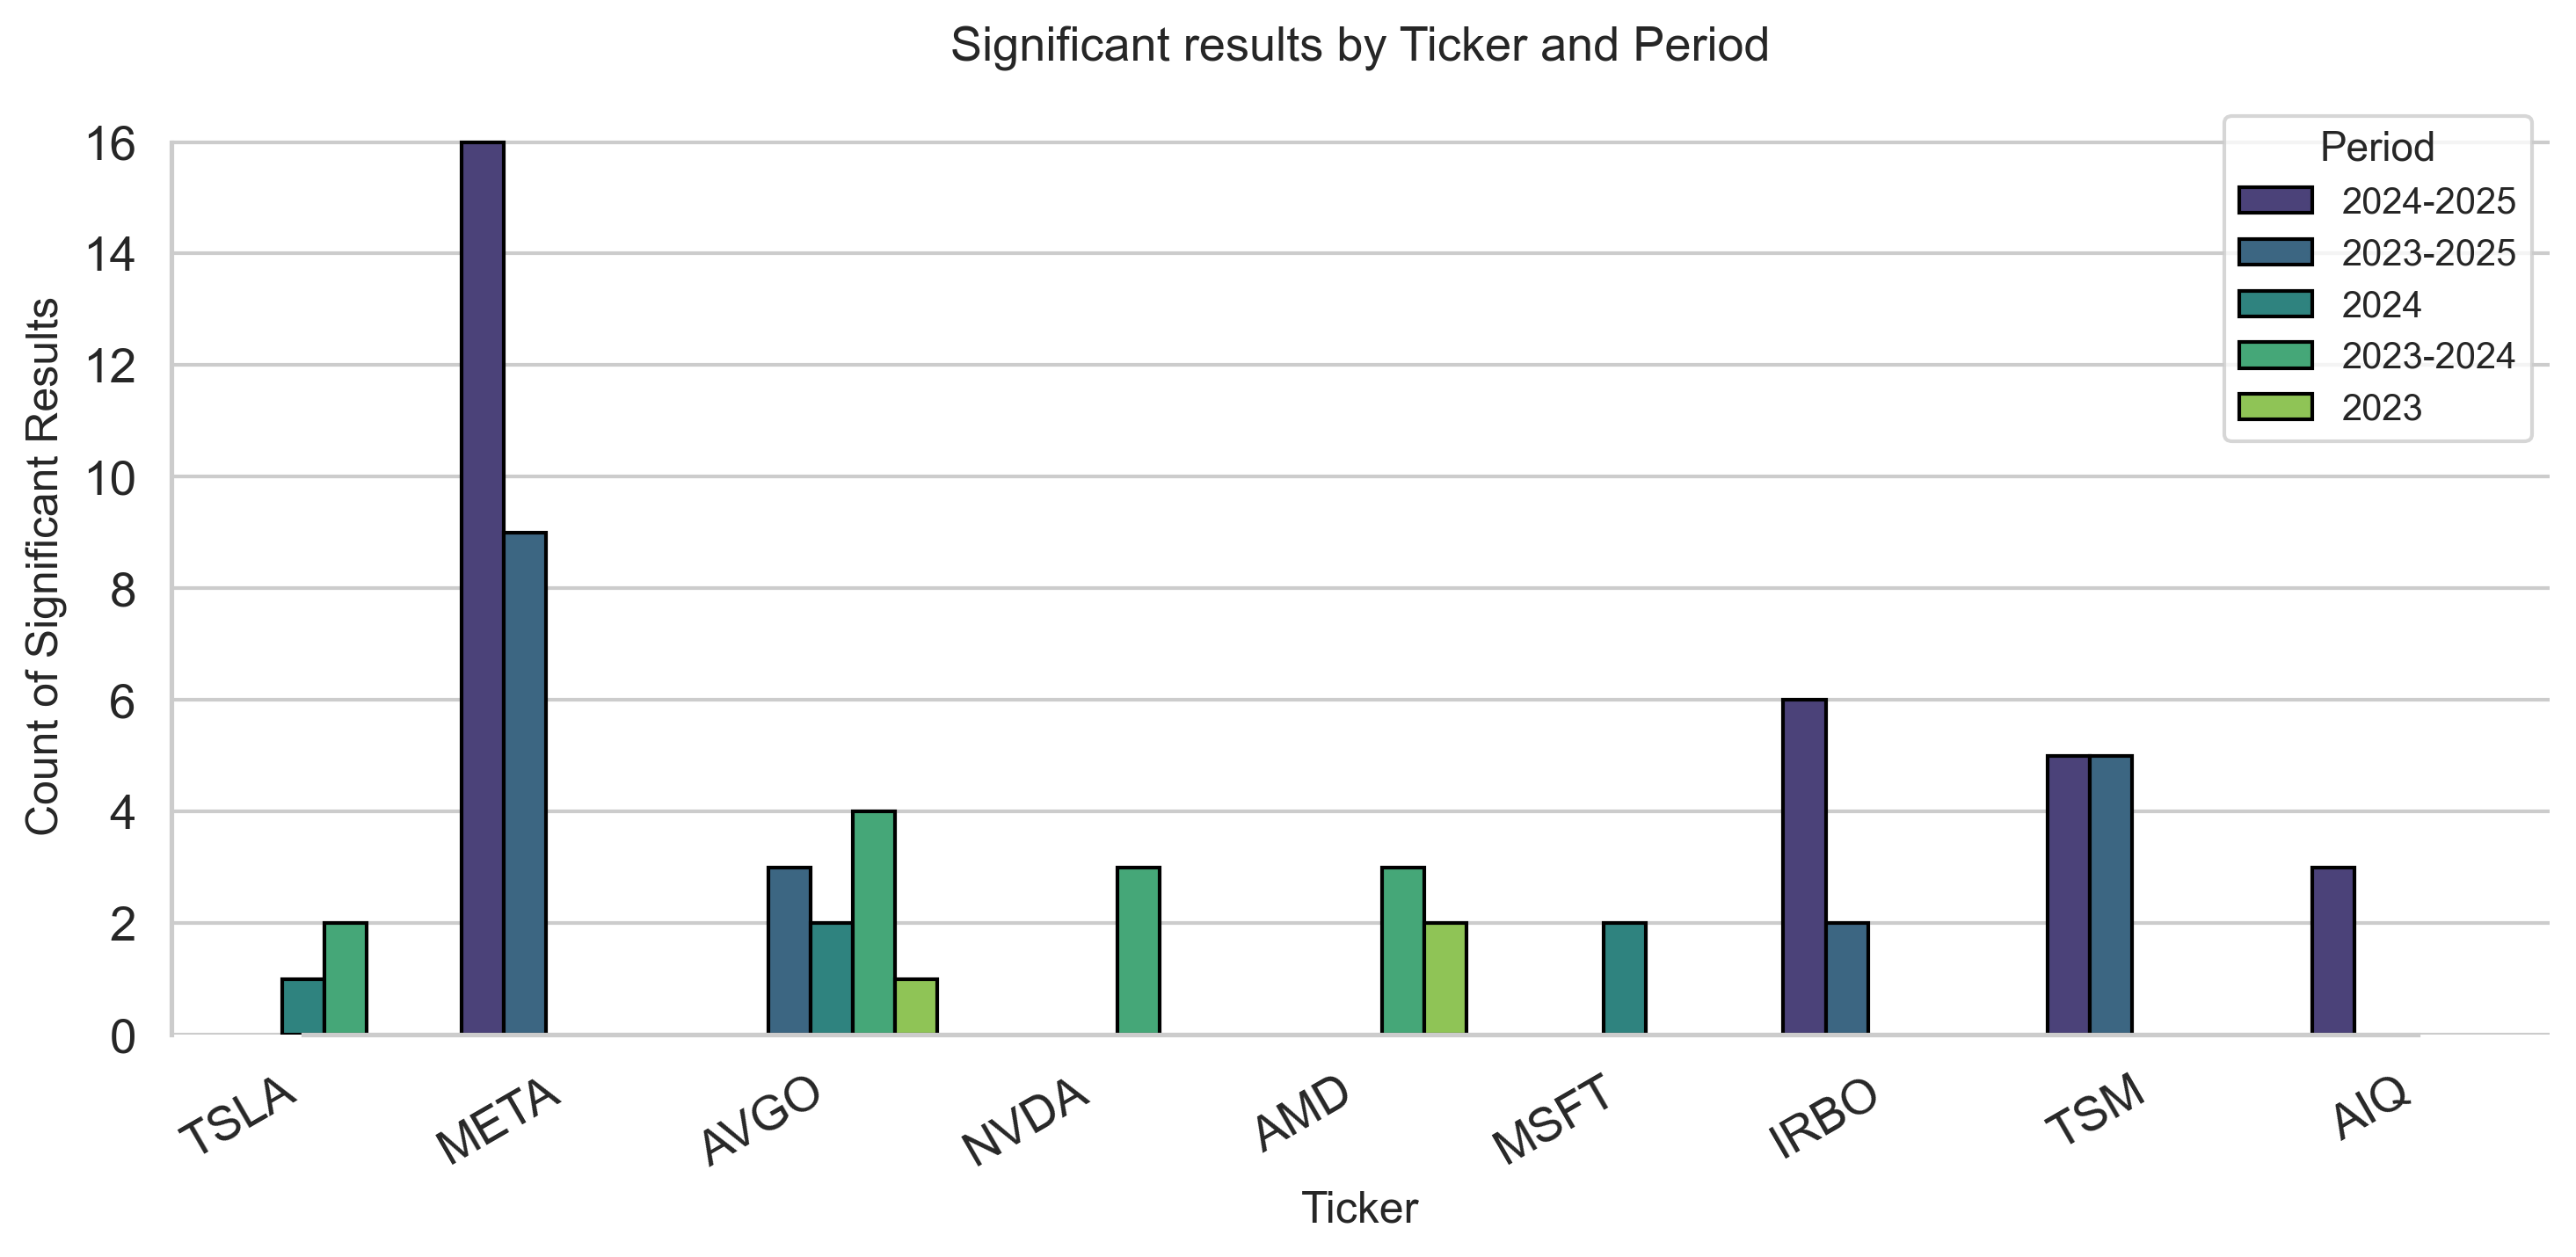

In [231]:
df = sp500_aini_to_ret_sig.copy()
df["Period"] = df["Period"].replace({
    "2023_24_25": "2023-2025",
    "2024_25": "2024-2025",
    "2023_24": "2023-2024"
}).astype(str)
df["Ticker"] = df["Ticker"].astype(str)

#  build order 
def period_key(p: str):
    years = list(map(int, re.findall(r"\d{4}", p)))
    if len(years) == 1:
        years = [years[0], years[0]]
    start, end = years[0], years[-1]
    return (end, start) 

periods = sorted(df["Period"].unique(), key=period_key, reverse=True)
df["Period"] = pd.Categorical(df["Period"], categories=periods, ordered=True)

# plot 
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 5), dpi=300)

ax = sns.countplot(
    data=df,
    x="Ticker",
    hue="Period",
    hue_order=periods,                          
    palette=sns.color_palette("viridis", n_colors=len(periods)),
    edgecolor="black"
)

ax.set_title("Significant results by Ticker and Period", fontsize=13, pad=10)
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Count of Significant Results", fontsize=12)
ax.legend(title="Period", title_fontsize=11, fontsize=10, loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(root_dir / "reports/figures/sp500_aini_to_ret_sig_counts.png", dpi=600, bbox_inches="tight")
plt.show()


In [212]:
# group by model
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

  Ticker  jointly rejected at α=0.1
4   META                         25
2   AVGO                         10
8    TSM                         10
3   IRBO                          8
1    AMD                          5
0    AIQ                          3
6   NVDA                          3
7   TSLA                          3
5   MSFT                          2


In [213]:
# group by model all
model_group_tickers = (
    sp500_aini_to_ret
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
0  custom                        765
1      w0                        675
2      w1                        675
3      w2                        675


In [214]:
# group by period
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)


       Period  jointly rejected at α=0.1
4     2024_25                         30
2  2023_24_25                         19
1     2023_24                         12
3        2024                          5
0        2023                          3


In [215]:
# group by period total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

       Period  jointly rejected at α=0.1
0        2023                        540
1     2023_24                        540
2  2023_24_25                        540
3        2024                        540
4     2024_25                        540
5        2025                         90


In [216]:
# group by Ticker
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

  Ticker  jointly rejected at α=0.1
4   META                         25
2   AVGO                         10
8    TSM                         10
3   IRBO                          8
1    AMD                          5
0    AIQ                          3
6   NVDA                          3
7   TSLA                          3
5   MSFT                          2


In [217]:
# group by Ticker total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
sp500_aini_to_ret

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,β2,γ2,γ2,β2,β3,γ3,γ3,β3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000063,0.105469,-0.014697,1,186,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000010,-0.011910,0.052793,3,342,1,...,-0.005393,-0.083715,NaN,NaN,-0.020141,0.062065,NaN,NaN,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,-0.000034,-0.012983,0.036714,3,342,1,...,-0.005284,-0.051728,NaN,NaN,-0.020233,0.035347,NaN,NaN,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001731,-0.090629,0.041505,3,342,1,...,0.014053,-0.492712,NaN,NaN,-0.091003,0.413345,NaN,NaN,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,1,...,0.011239,-0.100792,NaN,NaN,-0.094978,0.025708,NaN,NaN,w2,False


In [218]:
# group by period & Ticker
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
)


# print
print(model_group_tickers)

  Model  jointly rejected at α=0.1
0    w0                         23
1    w1                         46


In [219]:
# group by variant
model_group_measure = (
    sp500_aini_to_ret_sig
    .groupby(["AINI_variant"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)

print(model_group_measure)

      AINI_variant  n_variants
1           EMA_08          25
2  normalized_AINI          24
0           EMA_02          20


In [220]:
# find distinctions between models
keys = ["Ticker", "Period"]  
models = ["w0", "w1", "w2", "custom"]               

common_dfs = []
left_only_dfs = []
right_only_dfs = []

for m1, m2 in combinations(models, 2):
    df1 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m1, keys].drop_duplicates()
    df2 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m2, keys].drop_duplicates()

    # intersection
    common = df1.merge(df2, on=keys, how="inner")
    if not common.empty:
        common = common.assign(Model_pair=f"{m1}&{m2}")
        common_dfs.append(common)

    # only in left / only in right
    cmp = df1.merge(df2, on=keys, how="outer", indicator=True)
    left_only  = cmp.loc[cmp["_merge"] == "left_only",  keys].assign(only=m1)
    right_only = cmp.loc[cmp["_merge"] == "right_only", keys].assign(only=m2)

    if not left_only.empty:
        left_only_dfs.append(left_only)
    if not right_only.empty:
        right_only_dfs.append(right_only)

# Concatenate
common_all = pd.concat(common_dfs, ignore_index=True) if common_dfs else pd.DataFrame(columns=keys+["Model_pair"])
left_only_all = pd.concat(left_only_dfs, ignore_index=True) if left_only_dfs else pd.DataFrame(columns=keys+["only"])
right_only_all = pd.concat(right_only_dfs, ignore_index=True) if right_only_dfs else pd.DataFrame(columns=keys+["only"])

right_only_all

,Ticker,Period,only
0,AIQ,2024_25,w1
1,AMD,2023,w1
2,AMD,2023_24,w1
3,IRBO,2023_24_25,w1
4,IRBO,2024_25,w1
5,META,2023_24_25,w1
6,MSFT,2024,w1
7,TSM,2023_24_25,w1
8,TSM,2024_25,w1


In [221]:
keys = ["Ticker", "Period", "Model"]

# Defensive copies (optional but clean)
A = sp500_aini_to_ret_sig.copy()
B = sp500_ret_to_aini_sig.copy()

# Normalize data types
for c in keys:
    A[c] = A[c].astype(str)
    B[c] = B[c].astype(str)

# Build sets of unique tuples
S_A = set(map(tuple, A[keys].drop_duplicates().to_numpy()))
S_B = set(map(tuple, B[keys].drop_duplicates().to_numpy()))

# Compute intersection and counts
intersection = S_A & S_B
n_inter = len(intersection)

print(f"Common observations (unique {keys}): {n_inter}")
print(f"|A| = {len(S_A)}, |B| = {len(S_B)}, overlap = {n_inter / len(S_A):.2%} of A, {n_inter / len(S_B):.2%} of B")


Common observations (unique ['Ticker', 'Period', 'Model']): 3
|A| = 18, |B| = 22, overlap = 16.67% of A, 13.64% of B


In [222]:
# Jaccard for aini-Ret; ret -> AINI sp500_ret_to_aini_sig

In [ ]:
# investigate groups by Model
model_group_model = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)
print(model_group_model)


  Model  n_variants
1    w1          46
0    w0          23
Model     object
β1       float64
β2       float64
β3       float64
dtype: object


In [235]:
# ensure no duplicates
sp500_aini_to_ret_sig = sp500_aini_to_ret_sig.dropna(axis=1, how="all")
print(sp500_aini_to_ret_sig[["Model","β1","β2","β3"]].dtypes)

# plot distribution of betas
sp500_aini_to_ret_sig

# defines paths
out_path = root_dir / "reports" / "figures" / "distribution_of_betas.png"

# Config (
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# b columns (exclude b0)
beta_cols = [c for c in sp500_aini_to_ret_sig.columns if c.startswith("β") and c != "β₀"]

# Ensure consistent model order
models = ["w0", "w1"]

# Symmetric x-axis centered on 0 across ALL models
all_betas = sp500_aini_to_ret_sig[beta_cols]
all_betas = sp500_aini_to_ret_sig[beta_cols].to_numpy().astype(float).ravel()
all_betas = all_betas[~np.isnan(all_betas)]
lim = float(max(abs(all_betas.min()), abs(all_betas.max())))
xlim = (-lim, lim)

# Fixed y-limit
ymax = 15
bins = 40

# Plot
fig, axes = plt.subplots(1, 2, figsize=(7.2, 5.6), sharex=True, sharey=True)  # ~single-column friendly
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    subset = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == model, beta_cols]

    # Plot combined histograms 
    subset.plot.hist(
        bins=bins,
        range=xlim,         
        alpha=0.6,
        ax=ax,
        edgecolor="black",
        legend=True,         
    )

    # Titles / axes
    ax.set_title(f"Model: {model}")
    ax.set_xlim(xlim)
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Counts")         
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)

    # Means (β̄) per β, upper-right corner
    means = subset[beta_cols].mean().values

    # Map β-column names 
    beta_labels = []
    for j, col in enumerate(beta_cols, start=1):
        beta_labels.append(fr"$\bar{{\beta}}_{{{j}}}$={means[j-1]:.3f}")
    means_str = ", ".join(beta_labels)

    ax.text(
        0.98, 0.97, means_str,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=8.5,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )


# Ensure common x-label 
fig.text(0.5, 0.02, "", ha="center", fontsize=10)

# Grab labels from last axes 
handles, labels = axes[-1].get_legend_handles_labels()
for ax in axes:
    ax.legend_.remove()
fig.legend(handles, labels, title="Coefficient", loc="lower center", ncol=len(beta_cols), frameon=False)

# Tight layout 
plt.tight_layout(rect=[0.04, 0.07, 1, 0.98])

# Save
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.close(fig)

print(f"Saved: {out_path}")


Model     object
β1       float64
β2       float64
β3       float64
dtype: object
Saved: c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\distribution_of_betas.png


In [236]:
# plot distribution of betas
# defines paths
out_path = root_dir / "reports" / "figures" / "distribution_of_betas.png"

# Config (
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})


# b columns (exclude b0)
beta_cols = [c for c in sp500_aini_to_ret_sig.columns if c.startswith("β") and c != "β₀"]

# Ensure consistent model order
models = ["w0", "w1", "w2", "custom"]

# Symmetric x-axis centered on 0 across ALL models
all_betas = sp500_aini_to_ret_sig[beta_cols].to_numpy().astype(float).ravel()
all_betas = all_betas[~np.isnan(all_betas)]
lim = float(max(abs(all_betas.min()), abs(all_betas.max())))
xlim = (-lim, lim)

# Fixed y-limit
ymax = 23
bins = 40

# Plot
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.6), sharex=True, sharey=True)  # ~single-column friendly
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    subset = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == model, beta_cols]

    # Plot combined histograms 
    subset.plot.hist(
        bins=bins,
        range=xlim,         
        alpha=0.6,
        ax=ax,
        edgecolor="black",
        legend=True,         
    )

    # Titles / axes
    ax.set_title(f"Model: {model}")
    ax.set_xlim(xlim)
    ax.set_ylim(0, ymax)
    ax.set_ylabel("Counts")         
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)

    # Means (β̄) per β, upper-right corner
    means = subset[beta_cols].mean().values

    # Map β-column names 
    beta_labels = []
    for j, col in enumerate(beta_cols, start=1):
        beta_labels.append(fr"$\bar{{\beta}}_{{{j}}}$={means[j-1]:.3f}")
    means_str = ", ".join(beta_labels)

    ax.text(
        0.98, 0.97, means_str,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=8.5,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )


# Ensure common x-label 
fig.text(0.5, 0.02, "", ha="center", fontsize=10)

# Grab labels from last axes 
handles, labels = axes[-1].get_legend_handles_labels()
for ax in axes:
    ax.legend_.remove()
fig.legend(handles, labels, title="Coefficient", loc="lower center", ncol=len(beta_cols), frameon=False)

# Tight layout 
plt.tight_layout(rect=[0.04, 0.07, 1, 0.98])

# Save
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.close(fig)

print(f"Saved: {out_path}")


Saved: c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\distribution_of_betas.png


In [ ]:
# beautify
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24": "2023-2024"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2024_25": "2024-2025"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24_25": "2023-2025"})

In [ ]:
# sort by betas
sp500_aini_to_ret_sort = sp500_aini_to_ret_sig.assign(abs_β1=lambda x: x["β1"].abs()).sort_values("abs_β1", ascending=False)
sp500_aini_to_ret_sort_cut = sp500_aini_to_ret_sort.iloc[0:20]

# inspect 
sp500_aini_to_ret_sort_cut

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1),abs_β1
4316,w1,EMA_08,0.010834,TSM,2024-2025,2,-0.101388,0.015363,NaN,0.005570,-0.071725,NaN,0.066593,0.033546,True,0.101388
2664,w0,EMA_02,0.013007,META,2024-2025,2,-0.100842,-0.060111,NaN,-0.051435,-0.104461,NaN,0.051495,0.040546,True,0.100842
4284,w1,EMA_02,0.013615,META,2024-2025,2,-0.100779,-0.061591,NaN,-0.087081,-0.032126,NaN,0.009199,0.009591,True,0.100779
4828,w1,normalized_AINI,0.007920,META,2024-2025,3,-0.099884,-0.056303,0.000218,-0.014233,-0.040542,-0.019648,0.034097,0.024293,True,0.099884
4318,w1,normalized_AINI,0.013786,TSM,2024-2025,2,-0.099849,0.016960,NaN,0.010301,-0.070154,NaN,0.047695,0.022107,True,0.099849
4286,w1,EMA_08,0.015419,META,2024-2025,2,-0.099699,-0.059577,NaN,-0.024249,-0.054174,NaN,0.008099,0.004900,True,0.099699
4826,w1,EMA_08,0.007933,META,2024-2025,3,-0.099537,-0.056679,-0.000693,-0.019638,-0.050769,-0.007990,0.034097,0.024293,True,0.099537
4824,w1,EMA_02,0.009579,META,2024-2025,3,-0.098906,-0.055606,-0.000076,-0.064041,-0.172665,0.132826,0.034097,0.024293,True,0.098906
4288,w1,normalized_AINI,0.014226,META,2024-2025,2,-0.097766,-0.058140,NaN,-0.020398,-0.047991,NaN,0.008099,0.004900,True,0.097766
2666,w0,EMA_08,0.012248,META,2024-2025,2,-0.097286,-0.059179,NaN,-0.020109,-0.070010,NaN,0.051495,0.040546,True,0.097286


In [ ]:
# sorted latex output
export_regression_table(
    df=sp500_aini_to_ret_sort,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for S\\&P~500). \\textit{Source:} Own.",
    output_filename="gc_sp500_aini_to_ret_sort_beta",  
    output_format="tex",
    latex_env="tabular",          
    include_caption_label=False,    
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",   
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta.tex')

In [ ]:
export_regression_table(
    df=sp500_aini_to_ret_sort,
    title="Granger-Causality, jointly significant results (AINI → Returns, controlled for S&P 500)",
    output_filename="gc_sp500_aini_to_ret_sort_beta",
    output_format="tex",
    latex_env="longtable",         
    include_caption_label=True,    
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0,
    coef_digits=3,
    p_digits=3
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta.tex')

In [241]:
# beautify opposite direction 
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2023_24": "2023-2024"})
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2024_25": "2024-2025"})
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2023_24_25": "2023-2025"})

# drop NA
sp500_ret_to_aini_sig = sp500_ret_to_aini_sig.dropna(axis=1, how="all")

# sort by betas
sp500_ret_to_aini_sig_sort = sp500_ret_to_aini_sig.assign(abs_γ1=lambda x: x["γ1"].abs()).sort_values("abs_γ1", ascending=False)
sp500_ret_to_aini_sig_sort_cut = sp500_ret_to_aini_sig_sort.iloc[0:20]
sp500_ret_to_aini_sig

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1633,w0,EMA_02,0.469505,AMD,2023,1,0.033014,NaN,NaN,0.688648,NaN,NaN,0.090691,0.083308,True
1635,w0,EMA_08,-0.000339,AMD,2023,1,0.124531,NaN,NaN,0.002664,NaN,NaN,0.090691,0.083308,True
1637,w0,normalized_AINI,0.008475,AMD,2023,1,0.141245,NaN,NaN,-0.110102,NaN,NaN,0.090691,0.083308,True
2017,w0,EMA_02,0.693453,BOTZ,2023-2025,1,0.058895,NaN,NaN,0.837349,NaN,NaN,0.096890,0.076854,True
2143,w0,EMA_02,0.776700,ROBO,2024-2025,1,0.073155,NaN,NaN,0.887353,NaN,NaN,0.099290,0.057447,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,w1,EMA_08,0.245623,AMZN,2023-2025,3,-0.073013,-0.186509,0.069690,0.396509,0.075032,0.124132,0.071993,0.038405,True
4703,w1,normalized_AINI,0.138856,AMZN,2023-2025,3,-0.071949,-0.231003,0.067215,0.258425,0.126201,0.112444,0.081192,0.043869,True
4735,w1,EMA_02,0.790789,META,2023-2025,3,-0.041069,-0.050933,-0.003723,0.890304,-0.077634,0.076629,0.056394,0.026296,True
4737,w1,EMA_08,0.247155,META,2023-2025,3,-0.167832,-0.121318,0.001608,0.386016,0.065891,0.125538,0.056394,0.026296,True


In [ ]:
export_regression_table(
    df=sp500_ret_to_aini_sig_sort_cut,
    title="Granger-Causality, jointly significant results (Returns -> AINI, controlled for S&P 500), Top 20",
    output_filename="gc_sp500_ret_to_aini_sort_beta_cut",
    output_format="tex",
    latex_env="tabular",           
    include_caption_label=False,   
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0
)
sp500_ret_to_aini_sig_sort

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_ret_to_aini_sort_beta_cut.tex')

In [ ]:
export_regression_table(
    df=sp500_ret_to_aini_sig_sort,
    title="Granger-Causality, jointly significant results (Returns -> AINI, controlled for S&P 500), Top 20",
    output_filename="gc_sp500_ret_to_aini_sort_beta",
    output_format="tex",
    latex_env="tabular",           
    include_caption_label=False,   
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_ret_to_aini_sort_beta.tex')

Controlling for VIX

In [ ]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_VIX_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_VIX_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results_VIX = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results_VIX["joint rej. (α=0.1)"] = gc_all_results_VIX["BH_reject_F"] & gc_all_results_VIX["BH_reject_F_HC3"]

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_VIX= gc_all_results_VIX.rename(columns=rename_map)
gc_all_results_VIX

gc_all_results_VIX_for_report = gc_all_results_VIX.copy()

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_VIX_for_report = gc_all_results_VIX_for_report[(gc_all_results_VIX_for_report["Model"] == "custom") | (gc_all_results_VIX_for_report["Period"] != "2025")]
gc_all_results_VIX_for_report  = gc_all_results_VIX_for_report[~((gc_all_results_VIX_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_VIX_for_report["Period"] == "2025"))]

print(len(gc_all_results_VIX_for_report) / 2)

3735.0


In [ ]:
# subset by direction
vix_aini_to_ret = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "AINI_to_RET"]
vix_ret_to_aini = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "RET_to_AINI"]

# cols to keep
keep_a2r = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags", "β₀",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

keep_r2a = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags", "β₀",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

# subset
vix_aini_to_ret_sub = vix_aini_to_ret[keep_a2r]
vix_ret_to_aini_sub = vix_ret_to_aini[keep_r2a]
vix_ret_to_aini_sub

,Model,AINI_variant,Ticker,Period,Lags,β₀,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1,custom,EMA_02,AAPL,2023,1,NaN,NaN,-0.087203,NaN,NaN,...,NaN,NaN,0.761801,NaN,NaN,NaN,NaN,0.499150,0.479960,False
3,custom,EMA_08,AAPL,2023,1,NaN,NaN,-0.361555,NaN,NaN,...,NaN,NaN,0.241965,NaN,NaN,NaN,NaN,0.499150,0.479960,False
5,custom,normalized_AINI,AAPL,2023,1,NaN,NaN,-0.427160,NaN,NaN,...,NaN,NaN,0.090171,NaN,NaN,NaN,NaN,0.499150,0.479960,False
7,custom,normalized_AINI_z,AAPL,2023,1,NaN,NaN,-5.376787,NaN,NaN,...,NaN,NaN,0.090171,NaN,NaN,NaN,NaN,0.499150,0.479960,False
9,custom,EMA_02,AIQ,2023,1,NaN,NaN,0.118964,NaN,NaN,...,NaN,NaN,0.766042,NaN,NaN,NaN,NaN,0.847715,0.841159,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,w2,normalized_AINI_z,TSLA,2024_25,3,NaN,NaN,-0.760302,NaN,-1.280386,...,1.037670,NaN,0.213464,NaN,0.226110,NaN,0.130603,0.598540,0.527652,False
8633,w2,EMA_02,TSM,2024_25,3,NaN,NaN,0.017076,NaN,-0.003025,...,0.006249,NaN,0.864342,NaN,0.012425,NaN,0.052036,0.881512,0.845113,False
8635,w2,EMA_08,TSM,2024_25,3,NaN,NaN,0.040617,NaN,-0.087888,...,-0.023075,NaN,0.348606,NaN,0.174506,NaN,0.143414,0.881512,0.845113,False
8637,w2,normalized_AINI,TSM,2024_25,3,NaN,NaN,0.035925,NaN,-0.127019,...,-0.044359,NaN,0.210758,NaN,0.226635,NaN,0.134114,0.881512,0.845113,False


In [ ]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].astype(str)
vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].astype(str)

# Total number of models tested
total = vix_aini_to_ret_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = vix_aini_to_ret_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 3735
Both-method rejections: 210
Rejection rate: 5.62%


C:\Users\PC\AppData\Local\Temp\ipykernel_20104\3273238197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_20104\3273238197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].astype(str)


Investigate assets

In [ ]:
# beautify
vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].replace({"TSM": "TSMC"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24": "2023-2024"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2024_25": "2024-2025"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24_25": "2023-2025"})


C:\Users\PC\AppData\Local\Temp\ipykernel_20104\1777772733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].replace({"TSM": "TSMC"})
C:\Users\PC\AppData\Local\Temp\ipykernel_20104\1777772733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24": "2023-2024"})
C:\Users\PC\AppData\Local\Temp\ipykernel_20104\1777772733.py:4: SettingWithCopyWarning: 
A value is trying to

In [ ]:
# save merged results
gc_all_results_VIX.to_csv(var_path / "granger_causality_VIX.csv", index=False)

# define table path
table_path = root_dir / "reports" / "tables"

# Export as HTML for online appendix
gc_all_results.to_html(table_path / "granger_causality_VIX.html", index=False)

Controlled for VIX

Investigate results